In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import en_vectors_web_lg
from IPython.display import display_markdown
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from shared import models
from shared.data import load_fine_food_reviews
from shared.models_store import Store
from machine_learning.cache import get_preprocessed_data
from machine_learning.plot_helpers import display_example_predictions, describe_data
from machine_learning.evaluation import evaluate_and_report

Using TensorFlow backend.


In [2]:
nlp = en_vectors_web_lg.load()

In [3]:
MAX_WORDS_IN_SENTENCE = 200
TEXT_COLUMN = "Text"
LIMIT = -1
SAVE_IN_STORE = True
dataset_id = 'food_{}_{}'.format(TEXT_COLUMN.lower(), LIMIT if LIMIT > 0 else 'all')

## Data loading and preview

### Loading

In [4]:
X, y = load_fine_food_reviews(limit=LIMIT, text_column=TEXT_COLUMN)

test_count = min(2000, int(0.25 * len(X)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_count, random_state=42)

### Preview

In [5]:
describe_data(X, y)

display_markdown('### Train count: {}'.format(len(X_train)), raw=True)
display_markdown('### Test count:  {}'.format(len(X_test)), raw=True)

### Data sample

,X,y
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price. there was a wid...,1
5,i got a wild hair for taffy and ordered this f...,1
6,this saltwater taffy had great flavors and was...,1
7,this taffy is so good. it is very soft and ch...,1
8,right now i'm mostly just sprouting this so my...,1
9,this is a very healthy dog food. good for thei...,1


#### Text stats

count                                                525814
unique                                               363827
top       this review will make me sound really stupid, ...
freq                                                    199
Name: X, dtype: object

#### Words length stats

count    525814.000000
mean         79.016667
std          78.447587
min           3.000000
25%          33.000000
50%          55.000000
75%          96.000000
max        2520.000000
Name: X, dtype: float64

#### Most frequent words

like       216023
good       134313
great      125566
love       115641
taste      113093
coffee     102648
product     90767
tea         87843
flavor      82626
food        80930
little      73684
use         70361
buy         65173
find        64458
tried       63849
best        61051
eat         54302
dog         53589
try         51482
time        50342
dtype: int64

#### Labels stats

count    525814.000000
mean          0.843981
std           0.362874
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: y, dtype: float64

#### Labels counts

1    443777
0     82037
Name: y, dtype: int64

1    0.843981
0    0.156019
Name: y, dtype: float64

### Train count: 523814

### Test count:  2000

## Models

In [6]:
# helper for saving models for reuse in web application
store = Store(nlp, '../dist/store.json')
input_samples = [
    "We went there to eat dinner, and it was delicious",
    "One of the best suppers I've ever eaten",
    "Totally disgusting dish. I think cook made this with his eyes closed"
]

def train_model_and_display_results(model, X=X_train, y=y_train, **train_params):
    display_markdown('## {}'.format(model.__class__.__name__), raw=True)
    display_markdown('#### Training', raw=True)
    model.load_or_train(X, y, **train_params)

    display_markdown("#### Overview of created model", raw=True)
    display(model.summary())

    display_markdown('#### Model results', raw=True)
    display_example_predictions(model, input_samples)
    return evaluate_and_report(model, X_test, y_test)

Loading cached data...
Loaded data from 'kerasmodel_food_text_all.h5'


## KerasModel

#### Training

Loading model...
Model 'keras_food_text_all_b3f214f0.h5' loaded


#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

None

#### Model results

#### Predicted scores

,score,text
0,0.906017,"We went there to eat dinner, and it was delicious"
1,0.993009,One of the best suppers I've ever eaten
2,0.168423,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
1514,1.000000,0.999965,1,"love this coffee, have recommended and shared with friends. good smooth, strong and delicious flavor at an excellent price. i ..."
43,1.000000,0.999930,1,i have personally been on a mission to find my favorite jerky for a few years now. this is by far my favorite jerky - just a ...
762,1.000000,0.999923,1,"this was the perfect food for my finicky feline. my vet tried all the fancy prescription ""skinny"" foods and while they worked..."
1798,1.000000,0.999922,1,i love this company and i will use them time after time! my boyfriend and i adore these suckers and they taste amazing with go...
1870,1.000000,0.999914,1,"my girlfriend loves european milk chocolate and i got this for her. she loves it, and i am a happy dude.<br /><br />its very s..."


#### Lowest 5

,pred,prob,real,text
1843,0.000000,0.004004,0,i was hoping for some bulk inexpensive quality peanuts to make pb. this was not the case. they come in really cheap packaging ...
470,0.000000,0.005553,0,"this is my second time buying goji juice from this account. the 1st 2 bottles i bought were red, sweet, and tasted fruity. the..."
1392,0.000000,0.007893,0,this should be called sad baby--it's awful. my baby absolutely hates it! i tasted a tiny bit<br />and it was bland to the poin...
824,0.000000,0.010690,0,"disappointed!!!! not returnable, too bad. packaging from amazon seemed great as usual. and box was not crushed or battered ..."
510,0.000000,0.010715,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.997805,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1894,1.000000,0.996422,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."
440,1.000000,0.993576,0,"these have a great crunch and it's great that it's low fat. however, it's way too salty. 280mg per serving is more than twice ..."
998,1.000000,0.993002,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1500,1.000000,0.991314,0,i found no benefit in taking the kirkland energy shot where the 5 hour energy has me going in a few of minutes.<br /><br />in ...


#### Lowest 5 mispredicted

,pred,prob,real,text
1181,0.000000,0.014745,1,"one of the three packs was open before arriving. the paste was oozing out the side. i can't return it, and i am having a lot..."
393,0.000000,0.065325,1,"the popcorn is great. unfortunately, the bags are defective and the buttery flavoring has seeped out thus making the outside ..."
418,0.000000,0.117673,1,"the soup itself is very good tasting, and i would not hesitate to order it again except this is not the first time (including ..."
1939,0.000000,0.174862,1,"i place an order on july 11, 2011 of 15 (12 pack e/a) of vita coco coconut water with this horrible company ""goshoptnt"" and i ..."
402,0.000000,0.208973,1,these jelly beans are great for a party activity (think harry potter) or as a gag gift. there are 5-6 different colors of jell...


#### Classification report for keras

             precision    recall  f1-score   support

   Negative       0.91      0.47      0.62       313
   Positive       0.91      0.99      0.95      1687

avg / total       0.91      0.91      0.90      2000



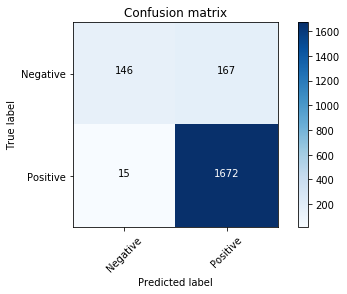

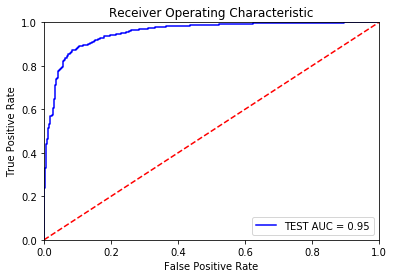

In [7]:
keras_model = models.KerasModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=5)

X_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id, X_train)

accuracy, y_pred_proba = train_model_and_display_results(keras_model, X_keras_preprocessed, preprocessed=True)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_food", "Food Reviews Conv1d", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_train),
        'Accuracy': accuracy,
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })

# we need memory for further processing
del X_keras_preprocessed

In [ ]:
from shared import transformers
text = np.array(["This so        nice lalala;.;,it's has the best"], dtype="object")
text = transformers.ClearTextTransformer().transform(text)
text = transformers.WordsToNlpIndexTransformer(nlp).transform(text)
text = transformers.NlpIndexToInputVectorTransformer(nlp, 200).transform(text)
print(text.shape)
print(keras_model.model.model.input_shape)
layers = keras_model.model.model.layers
for layer in layers:
    print('{}. {} - {}'.format(layer, layer.input_shape, layer.output_shape))


In [8]:
# preprocessed data for all sklearn-based models

model = models.SklearnModel(nlp, dataset_id)
X_sklearn_preprocessed = get_preprocessed_data(model, dataset_id, X_train)

Loading cached data...
Loaded data from 'sklearnmodel_food_text_all.h5'


## SVCModel

#### Training

Loading model...
Model 'svc_food_text_all_80e28a4f.pkl' loaded


#### Overview of created model

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Model results

#### Predicted scores

,score,text
0,0.996552,"We went there to eat dinner, and it was delicious"
1,0.999998,One of the best suppers I've ever eaten
2,0.001790,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
266,1.000000,1.000000,1,"a refreshing cold beverage and a soothing, perfect, hot cup of tea. offers healthful benefits."
1810,1.000000,1.000000,1,"a healthy choice for gum, great flavor. customer service was excellent - fast and courteous."
630,1.000000,1.000000,1,"great variety to keep on hand! friends and family will enjoy sampling with you. tea, hot chocolate, and many coffees. includ..."
1514,1.000000,1.000000,1,"love this coffee, have recommended and shared with friends. good smooth, strong and delicious flavor at an excellent price. i ..."
155,1.000000,1.000000,1,the oatmeal is delicious! great breakfast meal that is quick and easy! it's organic too!


#### Lowest 5

,pred,prob,real,text
824,0.000000,0.000083,0,"disappointed!!!! not returnable, too bad. packaging from amazon seemed great as usual. and box was not crushed or battered ..."
1390,0.000000,0.000264,0,i received this item poorly packaged and contents were scuffed and jumbled. it was meant for a gift and looked like a returned...
510,0.000000,0.000643,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."
1732,0.000000,0.000716,0,i should have known when the product told me to rinse it for several minutes to get rid of the putrid smell - smells like they...
850,0.000000,0.001358,0,"the cote d'or dark 86% brut chocolate cocoa, 3.5-ounce bars (pack of 10) is close to the worst chocolate i have eaten, if not ..."


#### Highest 5 mispredicted

,pred,prob,real,text
998,1.000000,1.000000,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1714,1.000000,1.000000,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1894,1.000000,0.995672,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."
1256,1.000000,0.994738,0,these crackers have no flavor what so ever and for 100 calories you get the same amount as the nabisco 100 calorie cookies. sa...
615,1.000000,0.994000,0,"i would rather spend the time and effort for a better flavor. the pods are individually sealed, and easy to use. the flavor is..."


#### Lowest 5 mispredicted

,pred,prob,real,text
811,0.000000,0.011772,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
1524,0.000000,0.018908,1,wish there was a better mix of black/brown hooves. the box contained mostly black hooves. otherwise the order was as decribed
1712,0.000000,0.024831,1,"what can i say, the deer and the antelop did not do anything to this coffee. neither did the caribou. it's ok, drinkable."
393,0.000000,0.029243,1,"the popcorn is great. unfortunately, the bags are defective and the buttery flavoring has seeped out thus making the outside ..."
142,0.000000,0.032724,1,"okay, i jumped the gun, because they were sending me the review information, before i received my chips, so i thought i would ..."


#### Classification report for svc

             precision    recall  f1-score   support

   Negative       0.68      0.55      0.61       313
   Positive       0.92      0.95      0.94      1687

avg / total       0.88      0.89      0.88      2000



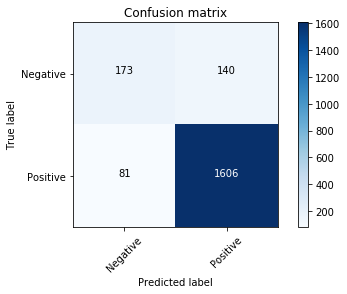

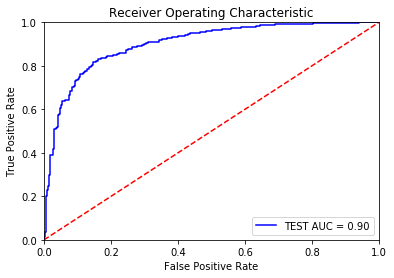

In [9]:
# it's almost impossible to train SVC on full dataset due to time complexity
svc_limit = min(20000, len(X_sklearn_preprocessed))
svc_model = models.SVCModel(
    nlp, dataset_id, 
    kernel="linear", C=0.025,
    probability=True)

accuracy, y_pred_proba = train_model_and_display_results(
    svc_model,
    X_sklearn_preprocessed[:svc_limit], 
    y_train[:svc_limit], 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(svc_model, "svc_food", "Food Reviews SVC", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': svc_limit,
        'Accuracy': accuracy,
        'Description': "SVM algorithm from Sklearn package. Trained on a reduced dataset due to O(n^2) time complexity"
    })


## DecisionTreeModel

#### Training

Loading model...
Model 'decisiontreeclassifier_food_text_all_5099b258.pkl' loaded


#### Overview of created model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Model results

#### Predicted scores

,score,text
0,0.956890,"We went there to eat dinner, and it was delicious"
1,0.964365,One of the best suppers I've ever eaten
2,0.775551,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
9,1.000000,0.987695,1,i purchased these to snack on after my workouts. now i find myself just snacking on them all the time!! they're really good an...
26,1.000000,0.987695,1,this tea kit is wonderful. it has wonderful tea that really does what it says. i love the heartburn tea. it helped when downin...
32,1.000000,0.987695,1,we love this mix! we use the muffin recipe on back and make donuts with our electric donut maker~yum. all the recipes on back...
41,1.000000,0.987695,1,i love this product it makes great lemon pepper wings. my mother actually recommended it to me.
42,1.000000,0.987695,1,"this is a great, yummy snack! it's healthy and easy to grab on the go and still tastes great. i would recommend it to anyone, ..."


#### Lowest 5

,pred,prob,real,text
74,0.000000,0.255414,1,i was of course wary of buying something as perishable as pine nuts over the internet whether from an amazon seller or not so ...
103,0.000000,0.255414,0,i wish i could give this stuff zero stars. it's bad enough that the label is deceptive and obviously meant to mislead consume...
244,0.000000,0.255414,0,i should have heeded the other reviewers who noted that this product was stale on arrival. same thing happened to me. amazon w...
278,0.000000,0.255414,0,"this candy was ok, but it had a different taste than the one we had previously bought at costco, even though it was supposed t..."
290,0.000000,0.255414,0,these crackers have a strong licorice flavor which is quite offputting. not at all what i expected. would not purchase this ...


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.987695,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1717,1.000000,0.987695,0,"the first couple of bags were great. really fresh, smooth, great taste. i thought i'd found the perfect coffee bean!! the next..."
1903,1.000000,0.987695,0,"i was very unimpressed with these almonds. they are very clovey and have a musty taste. if you are expecting a sweet treat, ..."
269,1.000000,0.965334,0,"i was looking forward to this product, as my wife and i both like earl grey tea, and decaf lets us drink it at night. we drin..."
384,1.000000,0.965334,0,the new taste of 2011 is not as good and tasty as the old one ... now the chocolate is hard and the liquid coffe is not the sa...


#### Lowest 5 mispredicted

,pred,prob,real,text
74,0.000000,0.255414,1,i was of course wary of buying something as perishable as pine nuts over the internet whether from an amazon seller or not so ...
1246,0.000000,0.255414,1,"the mushroom popcorn seemed to have about half pop nothing like the mushroom popcorn i've had before, it looks like regular po..."
1257,0.000000,0.255414,1,can't find anything wrong with this product. have used it twice already in baking and was pleased with the results.
1599,0.000000,0.255414,1,"i shared these cookies with my family and we all enjoyed them. as others have noted, they arrived in relatively poor conditio..."
1623,0.000000,0.255414,1,this by far the tastiest popcorn we have ever had. had to buy it in bulk for as much as we eat it!


#### Classification report for decisiontreeclassifier

             precision    recall  f1-score   support

   Negative       0.63      0.21      0.32       313
   Positive       0.87      0.98      0.92      1687

avg / total       0.83      0.86      0.83      2000



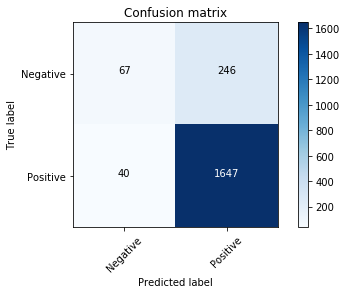

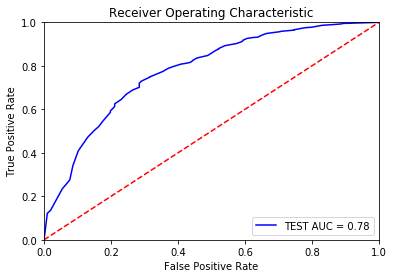

In [10]:
decision_tree_model = models.DecisionTreeModel(
    nlp, dataset_id, 
    max_depth=6)

accuracy, y_pred_proba = train_model_and_display_results(
    decision_tree_model, 
    X_sklearn_preprocessed, 
    preprocessed=True)

if SAVE_IN_STORE:
    store.add_model(decision_tree_model, "decision_tree_food", "Food Reviews Decision Tree", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Decision Tree algorithm from Sklearn package."
    })

## MLPModel

#### Training

Loading model...
Model 'mlpclassifier_food_text_all_75b9bd09.pkl' loaded


#### Overview of created model

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[50, 50], learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

#### Model results

#### Predicted scores

,score,text
0,0.999993,"We went there to eat dinner, and it was delicious"
1,1.000000,One of the best suppers I've ever eaten
2,0.269324,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
1905,1.000000,1.000000,1,this is the best tea in the world brings back childhood memories
32,1.000000,1.000000,1,we love this mix! we use the muffin recipe on back and make donuts with our electric donut maker~yum. all the recipes on back...
857,1.000000,1.000000,1,best addition to eggs and salads on the planet........put into soups by the german chefs for years adds a nice touch to meals
266,1.000000,1.000000,1,"a refreshing cold beverage and a soothing, perfect, hot cup of tea. offers healthful benefits."
1224,1.000000,1.000000,1,we have three darling shitzus. all of them adore booda bones and look forward to this wonderful treat. thank you amazon!!


#### Lowest 5

,pred,prob,real,text
864,0.000000,0.000001,0,"by far the most bitter coffee i have ever had in my life. like the donut shop blend, figured i'd try the others. this one is..."
1939,0.000000,0.000001,1,"i place an order on july 11, 2011 of 15 (12 pack e/a) of vita coco coconut water with this horrible company ""goshoptnt"" and i ..."
1299,0.000000,0.000011,0,"yuckity-yuck-yuck! the tulsi makes this much too bitter for me. i like some of the other honest teas, but i won't buy this f..."
1244,0.000000,0.000065,0,my cat wouldn't touch this stuff. i wound up giving it to the aspca.
1388,0.000000,0.000065,0,i had such high hopes for this apple cider but it was a huge disappointment...terribly sweet and an awful artificial flavor.


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.999698,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1256,1.000000,0.999552,0,these crackers have no flavor what so ever and for 100 calories you get the same amount as the nabisco 100 calorie cookies. sa...
1261,1.000000,0.986520,0,"these granola bars taste good, but they aren't kidding when they say that they're crunchy.<br /><br />i'm a little worried tha..."
1002,1.000000,0.984672,0,i was looking for miso soup and just bought this bowl in supermarket for comparison with instant miso soup in packages. i do...
1292,1.000000,0.979201,0,"despite the name, these are not really cupcakes. they're just flat cookies. the sprinkles fall off pretty easily, so be carefu..."


#### Lowest 5 mispredicted

,pred,prob,real,text
1939,0.000000,0.000001,1,"i place an order on july 11, 2011 of 15 (12 pack e/a) of vita coco coconut water with this horrible company ""goshoptnt"" and i ..."
556,0.000000,0.001094,1,"okay when i go to the beach i have to scrape barnacles off the side of my dad's boat- slimy, sticky, smelly barnacles. please..."
1801,0.000000,0.028716,1,as a diabetic it is constantly difficult to access saccaran products with all the phoney nutrasweet products being shelved ins...
786,0.000000,0.034120,1,"the flavors of the spices are right on for what i expect from jerky we've bought at the store, but making it ourselves made th..."
1181,0.000000,0.035432,1,"one of the three packs was open before arriving. the paste was oozing out the side. i can't return it, and i am having a lot..."


#### Classification report for mlpclassifier

             precision    recall  f1-score   support

   Negative       0.78      0.76      0.77       313
   Positive       0.96      0.96      0.96      1687

avg / total       0.93      0.93      0.93      2000



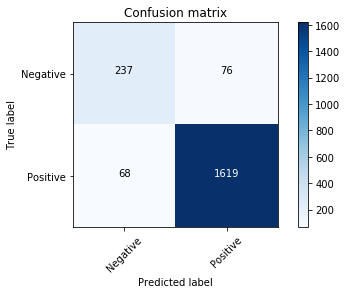

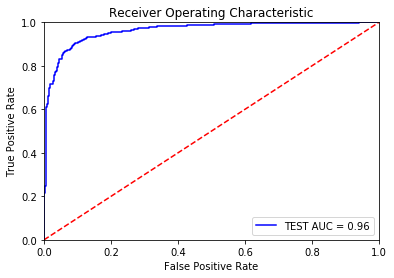

In [11]:
mlp_model = models.MLPModel(
    nlp, dataset_id,
    hidden_layer_sizes=[50, 50], 
    max_iter=100, 
    verbose=True)

accuracy, y_pred_proba = train_model_and_display_results(
    mlp_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(mlp_model, "mlp_food", "Food Reviews Multi-Layer Perceptron", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "MLP algorithm from Sklearn package, with 50x50 hidden layers sizes"
    })

## GaussianNBModel

#### Training

Loading model...
Model 'gaussiannb_food_text_all_d41d8cd9.pkl' loaded


#### Overview of created model

GaussianNB(priors=None)

#### Model results

#### Predicted scores

,score,text
0,1.000000,"We went there to eat dinner, and it was delicious"
1,1.000000,One of the best suppers I've ever eaten
2,0.999999,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
7,1.000000,1.000000,1,"i love mott's healthy harvest applesauce cups. it is only fruit-no added sugar. these are blueberry, but in stores you can als..."
19,1.000000,1.000000,1,this is the best red rooibos tea i have found!! recommend it to all my friends...
23,1.000000,1.000000,1,"these are a favorite candy treat but, for some reason, unavailable in local stores. delivery was in good time."
32,1.000000,1.000000,1,we love this mix! we use the muffin recipe on back and make donuts with our electric donut maker~yum. all the recipes on back...
33,1.000000,1.000000,1,"the best horseradish cheese i've ever tasted, i'm addicted. it's spicy and creamy. if you love horseradish this is a product y..."


#### Lowest 5

,pred,prob,real,text
544,0.000000,0.000000,0,"i really hesitate to leave a negative review since we love the chips, but both of the last 2 shipments were destroyed. both b..."
811,0.000000,0.000000,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
1462,0.000000,0.000000,0,"i hope someone in charge of this sale reads this, because of all the cans in the two cases of soup i ordered, easily 75% of th..."
1367,0.000000,0.000000,0,"i have bought three bottles of this product. i have not felt any better; most of the time, i have felt much worse. i was under..."
1834,0.000000,0.000000,0,"i got the case of beans in the mail yesterday. today when i got a chance to open the box, every single can was dented. the s..."


#### Highest 5 mispredicted

,pred,prob,real,text
364,1.000000,1.000000,0,"this chai latte mix is weak and not creamy. for starbucks like taste, try the big train canister."
440,1.000000,1.000000,0,"these have a great crunch and it's great that it's low fat. however, it's way too salty. 280mg per serving is more than twice ..."
998,1.000000,1.000000,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1137,1.000000,1.000000,0,"dry, tasteless. no carrot flavor. no spice flavor. go raw has some awesome cookies. this is not one of them. stay with the lem..."
1256,1.000000,1.000000,0,these crackers have no flavor what so ever and for 100 calories you get the same amount as the nabisco 100 calorie cookies. sa...


#### Lowest 5 mispredicted

,pred,prob,real,text
811,0.000000,0.000000,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
142,0.000000,0.000000,1,"okay, i jumped the gun, because they were sending me the review information, before i received my chips, so i thought i would ..."
902,0.000000,0.000000,1,i bought a 'jar' because its sweetened with xylitol. i was skeptical after my first piece. yes the intense peppermint rush see...
1631,0.000000,0.000000,1,"product arrived as promised. i thought the shipping was extremely high and had i realized it was that high, i would not have ..."
314,0.000000,0.000000,1,"i've been using these bags for only three weeks now, and so far no complaints. they seal easily, haven't leaked yet, quality f..."


#### Classification report for gaussiannb

             precision    recall  f1-score   support

   Negative       0.29      0.76      0.42       313
   Positive       0.94      0.66      0.78      1687

avg / total       0.84      0.68      0.72      2000



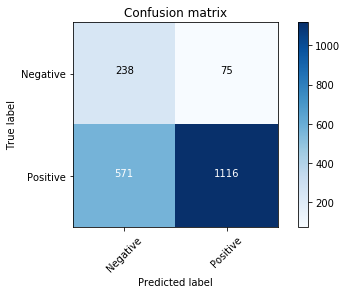

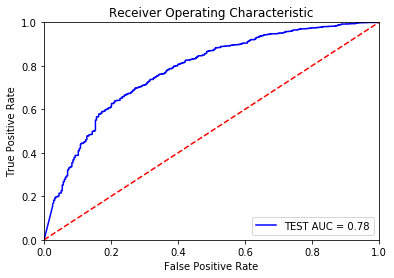

In [12]:
gaussian_nb_model = models.GaussianNBModel(
    nlp, dataset_id
)

accuracy, y_pred_proba = train_model_and_display_results(
    gaussian_nb_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)


if SAVE_IN_STORE:
    store.add_model(gaussian_nb_model, "gnb_food", "Food Reviews Gaussian Naive Bayes", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "GaussianNB algorithm from Sklearn package, default options"
    })

## AdaBoostModel

#### Training

Loading model...
Model 'adaboostclassifier_food_text_all_d41d8cd9.pkl' loaded


#### Overview of created model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

#### Model results

#### Predicted scores

,score,text
0,0.517725,"We went there to eat dinner, and it was delicious"
1,0.523714,One of the best suppers I've ever eaten
2,0.497010,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
1550,1.000000,0.543648,1,what great cup of coffee! i recommend it to any coffee drinker who enjoys sitting back and enjoying what coffee is all about....
115,1.000000,0.543614,1,jack link's beef jerky is a quick and great tasting way to get extra protein into your diet. a great snack. i really like th...
345,1.000000,0.542702,1,this is a healthy and good snack for my dog. it is a great training produst too. when you take into account that a couple ar...
42,1.000000,0.541621,1,"this is a great, yummy snack! it's healthy and easy to grab on the go and still tastes great. i would recommend it to anyone, ..."
266,1.000000,0.541147,1,"a refreshing cold beverage and a soothing, perfect, hot cup of tea. offers healthful benefits."


#### Lowest 5

,pred,prob,real,text
850,0.000000,0.477236,0,"the cote d'or dark 86% brut chocolate cocoa, 3.5-ounce bars (pack of 10) is close to the worst chocolate i have eaten, if not ..."
1811,0.000000,0.477525,0,"at first i thoughts it tasted like soy flour was used as it had a similar smell; however, it is garbanzo bean flour???????????..."
510,0.000000,0.479744,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."
1732,0.000000,0.482792,0,i should have known when the product told me to rinse it for several minutes to get rid of the putrid smell - smells like they...
303,0.000000,0.483845,0,simply terrible. awful. i've never tasted a worse espresso in my life.<br /><br />ecc espressivo vs. nespresso roma vs. nesp...


#### Highest 5 mispredicted

,pred,prob,real,text
1894,1.000000,0.530793,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."
998,1.000000,0.525232,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1714,1.000000,0.524620,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1170,1.000000,0.521695,0,you get what you pay for with this product. i drink matcha tea daily and absolutely love it. when i saw the price and review...
1002,1.000000,0.520980,0,i was looking for miso soup and just bought this bowl in supermarket for comparison with instant miso soup in packages. i do...


#### Lowest 5 mispredicted

,pred,prob,real,text
1792,0.000000,0.488149,1,i haven't had any problems with this tea so i am a notch above indifferent. i don't regret buying it.
1149,0.000000,0.489645,1,"good stuff. i despise the taste of processed sweetners and i was hesitant about what they would taste like, but i was not disa..."
811,0.000000,0.490724,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
1181,0.000000,0.490780,1,"one of the three packs was open before arriving. the paste was oozing out the side. i can't return it, and i am having a lot..."
1164,0.000000,0.490866,1,"we had to use this formula b/c my son ended up with serious gi issues, and this was the only thing he tolerated. he was (is) s..."


#### Classification report for adaboostclassifier

             precision    recall  f1-score   support

   Negative       0.64      0.40      0.50       313
   Positive       0.90      0.96      0.93      1687

avg / total       0.86      0.87      0.86      2000



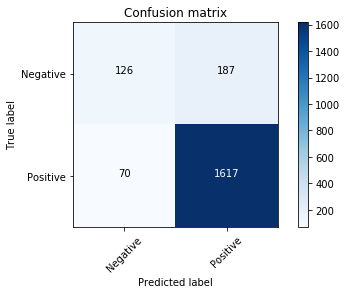

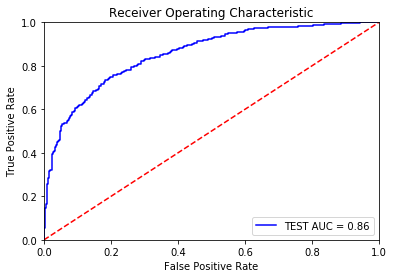

In [13]:
ada_boost_model = models.AdaBoostModel(
    nlp, dataset_id
)

accuracy, y_pred_proba = train_model_and_display_results(
    ada_boost_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(ada_boost_model, "ada_food", "Food Reviews Ada Boost", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Ada Boost algorithm from Sklearn package, default options"
    })

## QuadraticDiscriminantAnalysisModel

#### Training

Loading model...
Model 'quadraticdiscriminantanalysis_food_text_all_d41d8cd9.pkl' loaded


#### Overview of created model

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

#### Model results

#### Predicted scores

,score,text
0,1.000000,"We went there to eat dinner, and it was delicious"
1,1.000000,One of the best suppers I've ever eaten
2,0.999884,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
3,1.000000,1.000000,1,i just found pb2 and pb2 with chocolate and i am thrilled. i love sugary goodies but i'm not a fan of calories and i don't li...
5,1.000000,1.000000,1,"i bought this mix for my father after a recommendation from a friend, and my father loves it so much, i had to order more for ..."
19,1.000000,1.000000,1,this is the best red rooibos tea i have found!! recommend it to all my friends...
20,1.000000,1.000000,0,"i'm sticking with what used to be carnation, now nestles malt. this stuff tastes like powdered milk with a hint of soy."
23,1.000000,1.000000,1,"these are a favorite candy treat but, for some reason, unavailable in local stores. delivery was in good time."


#### Lowest 5

,pred,prob,real,text
1811,0.000000,0.000000,0,"at first i thoughts it tasted like soy flour was used as it had a similar smell; however, it is garbanzo bean flour???????????..."
631,0.000000,0.000000,0,i puchase regular soda because i am allergic to artificial sweeteners. why is there artificial sweetener in a regular soda syrup?
625,0.000000,0.000000,0,taste delicious but loaded with hydrogenated oil.hydrogenated oil is synthetically made trans fats that has been molecularly ...
894,0.000000,0.000000,0,"it has a weird sickly sweet aftertaste. plus, it has edta in it, which is on the fda's toxicity watchlist"
510,0.000000,0.000000,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."


#### Highest 5 mispredicted

,pred,prob,real,text
20,1.000000,1.000000,0,"i'm sticking with what used to be carnation, now nestles malt. this stuff tastes like powdered milk with a hint of soy."
1714,1.000000,1.000000,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
364,1.000000,1.000000,0,"this chai latte mix is weak and not creamy. for starbucks like taste, try the big train canister."
224,1.000000,1.000000,0,disappointed with the red lentils because they cook down to a mush. no discernable shapes of lentils are present when finishe...
1256,1.000000,1.000000,0,these crackers have no flavor what so ever and for 100 calories you get the same amount as the nabisco 100 calorie cookies. sa...


#### Lowest 5 mispredicted

,pred,prob,real,text
811,0.000000,0.000000,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
1939,0.000000,0.000000,1,"i place an order on july 11, 2011 of 15 (12 pack e/a) of vita coco coconut water with this horrible company ""goshoptnt"" and i ..."
610,0.000000,0.000000,1,"the product is very good and i like it but what i don't like and i must know before i make my order the product date, i discov..."
1573,0.000000,0.000000,1,"boxes contain 45 packs, hence the 90 bars so don't be surprised, comes out to about .47 a pack and at work they are .70 so it'..."
1765,0.000000,0.000000,1,edit!<br />kudos to the seller for correcting the picture.<br /><br />old review - no longer valid:<br />they should not put a...


#### Classification report for quadraticdiscriminantanalysis

             precision    recall  f1-score   support

   Negative       0.41      0.82      0.55       313
   Positive       0.96      0.78      0.86      1687

avg / total       0.87      0.79      0.81      2000



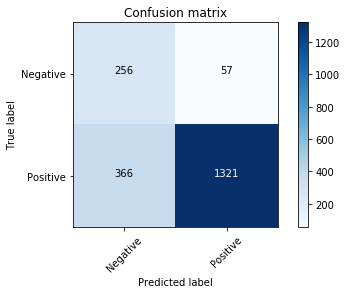

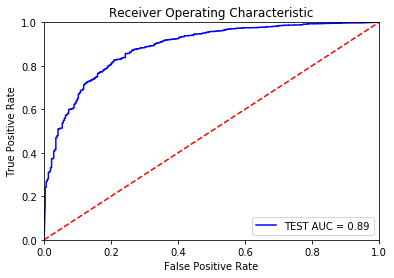

In [15]:
# Due to memory problems lowered amount of samples
qda_limit = min(200000, len(X_sklearn_preprocessed))
qda_model = models.QuadraticDiscriminantAnalysisModel(
    nlp, dataset_id
)

accuracy, y_pred_proba = train_model_and_display_results(
    qda_model,
    X_sklearn_preprocessed[:qda_limit], 
    y_train[:qda_limit],
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(qda_model, "qda_food", "Food Reviews Quadratic Discriminant Analysis", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': qda_limit,
        'Accuracy': accuracy,
        'Description': "Quadratic Discriminant Analysis algorithm from Sklearn package, default options"
    })

## LogisticRegressionModel

#### Training

Loading model...
Model 'logisticregression_food_text_all_90795899.pkl' loaded


#### Overview of created model

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Model results

#### Predicted scores

,score,text
0,0.994977,"We went there to eat dinner, and it was delicious"
1,0.999998,One of the best suppers I've ever eaten
2,0.000945,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
1810,1.000000,1.000000,1,"a healthy choice for gum, great flavor. customer service was excellent - fast and courteous."
266,1.000000,1.000000,1,"a refreshing cold beverage and a soothing, perfect, hot cup of tea. offers healthful benefits."
1383,1.000000,0.999999,1,these are great training & reinforcement treats. my dogs love them and they are a good bargain. highly recommend them!
155,1.000000,0.999999,1,the oatmeal is delicious! great breakfast meal that is quick and easy! it's organic too!
1651,1.000000,0.999998,1,love everything about these 8.25-ounce cartons: they are shelf stable and very portable. highly recommend.


#### Lowest 5

,pred,prob,real,text
1811,0.000000,0.000453,0,"at first i thoughts it tasted like soy flour was used as it had a similar smell; however, it is garbanzo bean flour???????????..."
510,0.000000,0.000989,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."
1390,0.000000,0.001584,0,i received this item poorly packaged and contents were scuffed and jumbled. it was meant for a gift and looked like a returned...
1732,0.000000,0.002072,0,i should have known when the product told me to rinse it for several minutes to get rid of the putrid smell - smells like they...
850,0.000000,0.002553,0,"the cote d'or dark 86% brut chocolate cocoa, 3.5-ounce bars (pack of 10) is close to the worst chocolate i have eaten, if not ..."


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.999407,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
998,1.000000,0.997935,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1894,1.000000,0.994159,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."
615,1.000000,0.986067,0,"i would rather spend the time and effort for a better flavor. the pods are individually sealed, and easy to use. the flavor is..."
440,1.000000,0.985454,0,"these have a great crunch and it's great that it's low fat. however, it's way too salty. 280mg per serving is more than twice ..."


#### Lowest 5 mispredicted

,pred,prob,real,text
1712,0.000000,0.022688,1,"what can i say, the deer and the antelop did not do anything to this coffee. neither did the caribou. it's ok, drinkable."
1792,0.000000,0.057498,1,i haven't had any problems with this tea so i am a notch above indifferent. i don't regret buying it.
1252,0.000000,0.066406,1,the tower was what i wanted for family gifts. didn't get to view the contents but i am sure they were ok
393,0.000000,0.070670,1,"the popcorn is great. unfortunately, the bags are defective and the buttery flavoring has seeped out thus making the outside ..."
811,0.000000,0.074863,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...


#### Classification report for logisticregression

             precision    recall  f1-score   support

   Negative       0.76      0.53      0.62       313
   Positive       0.92      0.97      0.94      1687

avg / total       0.89      0.90      0.89      2000



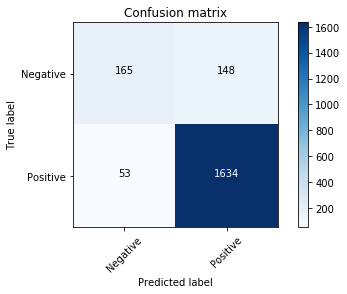

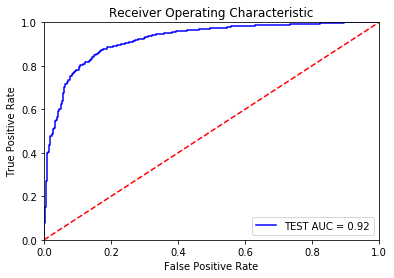

In [16]:
logistic_regression_limit = min(100000, len(X_sklearn_preprocessed))

logistic_regression = models.LogisticRegressionModel(
    nlp, dataset_id,
    C=1e5
)

accuracy, y_pred_proba = train_model_and_display_results(
    logistic_regression,
    X_sklearn_preprocessed[:logistic_regression_limit],
    y_train[:logistic_regression_limit],
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(logistic_regression, "logistic_reg_food", "Food Reviews Logistic Regression", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': logistic_regression_limit,
        'Accuracy': accuracy,
        'Description': "Logistic Regression Analysis algorithm from Sklearn package, default options except C=1e5"
    })

## GradientBoostingModel

#### Training

Loading model...
Model 'gradientboostingclassifier_food_text_all_c002d57a.pkl' loaded


#### Overview of created model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False)

#### Model results

#### Predicted scores

,score,text
0,0.928286,"We went there to eat dinner, and it was delicious"
1,0.946490,One of the best suppers I've ever eaten
2,0.766118,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
1514,1.000000,0.980749,1,"love this coffee, have recommended and shared with friends. good smooth, strong and delicious flavor at an excellent price. i ..."
266,1.000000,0.980010,1,"a refreshing cold beverage and a soothing, perfect, hot cup of tea. offers healthful benefits."
1550,1.000000,0.978740,1,what great cup of coffee! i recommend it to any coffee drinker who enjoys sitting back and enjoying what coffee is all about....
1072,1.000000,0.977439,1,"it is chocolate, what can i say. great variety of everything our family loves. with a family of six it goes fast here. perf..."
1056,1.000000,0.977383,1,i have been searching for a great midday snack that is gluten free and i have finally found it. the almond and apricot kind ba...


#### Lowest 5

,pred,prob,real,text
850,0.000000,0.180858,0,"the cote d'or dark 86% brut chocolate cocoa, 3.5-ounce bars (pack of 10) is close to the worst chocolate i have eaten, if not ..."
544,0.000000,0.215153,0,"i really hesitate to leave a negative review since we love the chips, but both of the last 2 shipments were destroyed. both b..."
510,0.000000,0.215427,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."
1834,0.000000,0.235895,0,"i got the case of beans in the mail yesterday. today when i got a chance to open the box, every single can was dented. the s..."
1462,0.000000,0.235977,0,"i hope someone in charge of this sale reads this, because of all the cans in the two cases of soup i ordered, easily 75% of th..."


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.957823,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1894,1.000000,0.957432,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."
998,1.000000,0.955181,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1237,1.000000,0.945899,0,i gave oregon chai a try when my local grocery store didn't have tazo. big mistake! it's somehow watery tasting and too sweet ...
1180,1.000000,0.942984,0,we love clif kid z bars. i decided to try these based on all of the great reviews. we bought the strawberry and no one in th...


#### Lowest 5 mispredicted

,pred,prob,real,text
811,0.000000,0.292569,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
1257,0.000000,0.360199,1,can't find anything wrong with this product. have used it twice already in baking and was pleased with the results.
1712,0.000000,0.368628,1,"what can i say, the deer and the antelop did not do anything to this coffee. neither did the caribou. it's ok, drinkable."
1792,0.000000,0.370531,1,i haven't had any problems with this tea so i am a notch above indifferent. i don't regret buying it.
1181,0.000000,0.381822,1,"one of the three packs was open before arriving. the paste was oozing out the side. i can't return it, and i am having a lot..."


#### Classification report for gradientboostingclassifier

             precision    recall  f1-score   support

   Negative       0.81      0.19      0.31       313
   Positive       0.87      0.99      0.93      1687

avg / total       0.86      0.87      0.83      2000



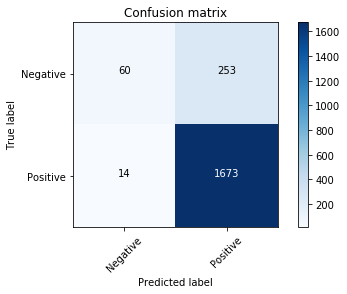

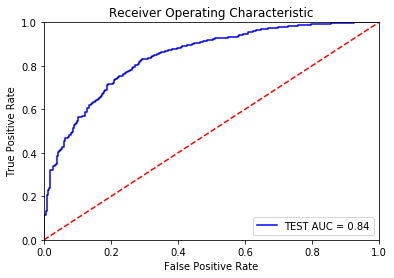

In [17]:
gradient_boosting_model = models.GradientBoostingModel(
    nlp, dataset_id,
    n_estimators=50, 
    max_depth=2,
    verbose=2
)

accuracy, y_pred_proba = train_model_and_display_results(
    gradient_boosting_model,
    X_sklearn_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(gradient_boosting_model, "gradient_boost_food", "Food Reviews Gradient Boosting", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Accuracy': accuracy,
        'Description': "Gradient Boosting algorithm from Sklearn package, n_estimators=50, max_depth=2"
    })

## XGBModel

#### Training

Loading model...
Model 'xgbclassifier_food_text_all_5d69fa9f.pkl' loaded


#### Overview of created model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose_eval=1)

#### Model results

#### Predicted scores

,score,text
0,0.961445,"We went there to eat dinner, and it was delicious"
1,0.983915,One of the best suppers I've ever eaten
2,0.314221,Totally disgusting dish. I think cook made this with his eyes closed


#### Highest 5

,pred,prob,real,text
1021,1.000000,0.997449,1,i enjoyed this bar very much. it is a perfect combination of peanut butter and chocolate. you can tell they are healthy but t...
1514,1.000000,0.997302,1,"love this coffee, have recommended and shared with friends. good smooth, strong and delicious flavor at an excellent price. i ..."
1548,1.000000,0.997127,1,"i was looking for some great matcha that i can use for tea, lattes, etc. this is wonderful! i use my hand mixer to blend it in..."
266,1.000000,0.997038,1,"a refreshing cold beverage and a soothing, perfect, hot cup of tea. offers healthful benefits."
155,1.000000,0.996951,1,the oatmeal is delicious! great breakfast meal that is quick and easy! it's organic too!


#### Lowest 5

,pred,prob,real,text
510,0.000000,0.043928,0,"bought the teriyaki flavor .....totally gross,<br /><br />do not waste your money on this slimy stuff.... could barely finish ..."
850,0.000000,0.054141,0,"the cote d'or dark 86% brut chocolate cocoa, 3.5-ounce bars (pack of 10) is close to the worst chocolate i have eaten, if not ..."
1462,0.000000,0.072552,0,"i hope someone in charge of this sale reads this, because of all the cans in the two cases of soup i ordered, easily 75% of th..."
544,0.000000,0.088345,0,"i really hesitate to leave a negative review since we love the chips, but both of the last 2 shipments were destroyed. both b..."
234,0.000000,0.099541,0,"<a href=""http://www.amazon.com/gp/product/b003ybnivu"">la panzanella tomato-oregano croccantini box, 5-ounce boxes (pack of 12)..."


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.987694,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
384,1.000000,0.972479,0,the new taste of 2011 is not as good and tasty as the old one ... now the chocolate is hard and the liquid coffe is not the sa...
998,1.000000,0.968970,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
440,1.000000,0.968315,0,"these have a great crunch and it's great that it's low fat. however, it's way too salty. 280mg per serving is more than twice ..."
1894,1.000000,0.967097,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."


#### Lowest 5 mispredicted

,pred,prob,real,text
811,0.000000,0.221032,1,i had mole problems and i killed the bugs. i had killed the whole yard to replant and don't know if there were less bugs in t...
1902,0.000000,0.227559,1,i have ordered on 2 separate occasions the 4 pack boxes. both had terrific groats but the first shipment one of the 4 packs h...
1181,0.000000,0.246403,1,"one of the three packs was open before arriving. the paste was oozing out the side. i can't return it, and i am having a lot..."
74,0.000000,0.286812,1,i was of course wary of buying something as perishable as pine nuts over the internet whether from an amazon seller or not so ...
1149,0.000000,0.308501,1,"good stuff. i despise the taste of processed sweetners and i was hesitant about what they would taste like, but i was not disa..."


#### Classification report for xgbclassifier

             precision    recall  f1-score   support

   Negative       0.74      0.34      0.47       313
   Positive       0.89      0.98      0.93      1687

avg / total       0.87      0.88      0.86      2000



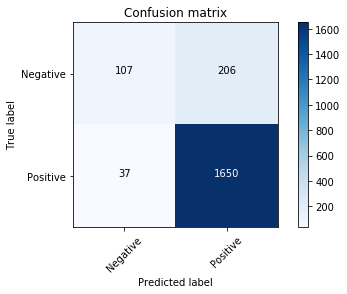

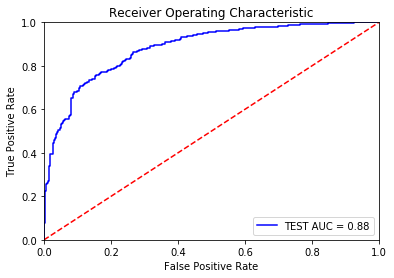

In [18]:
xgb_limit = min(50000, len(X_sklearn_preprocessed))
xgb_model = models.XGBModel(
    nlp, dataset_id, verbose_eval=1
)

accuracy, y_pred_proba = train_model_and_display_results(
    xgb_model,
    X_sklearn_preprocessed[:xgb_limit],
    y_train[:xgb_limit],
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(xgb_model, "xgboost_food", "Food Reviews XGBoost", metadata={
        'Y Test': [int(r[0]) for r in y_test],
        'Y Pred Proba': [float(r) for r in y_pred_proba],
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': xgb_limit,
        'Accuracy': accuracy,
        'Description': "XGBoost using default parameters"
    })